<a href="https://colab.research.google.com/github/KarinaPapayia/2Dim-compound-poisson/blob/master/testwdcgan_gp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import random
import torch
import torch.nn as nn
import torch.autograd as autograd
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torchvision.datasets import CIFAR10
import matplotlib.pyplot as plt
from datetime import datetime
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

Using device: cuda



In [ ]:
ModelStorage = './checkpoints'

# Explicit seed for the reproducibility of the results
seed = 42
random.seed(seed)
torch.manual_seed(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
def cuda(x):
    if torch.cuda.is_available():
        x = x.cuda()

    return x

#Data processing

In [ ]:

def normalize_real_images(real_images):
    min_value = real_images.min()
    max_value = real_images.max()

    normalized_images = 2 * (real_images - min_value) / (max_value - min_value) - 1

    return normalized_images

In [ ]:
#set the image values from [0,1] to [-1, 1]
preprocessing_ops = transforms.Compose([transforms.ToTensor()])

# Dataset download
train_dataset = CIFAR10(root="./data", train = True, transform = preprocessing_ops, download = True)
test_dataset = CIFAR10(root="../data", train = False, transform = preprocessing_ops, download = True)

# Label of class to use for training (3 = cats)
class_label = 3

# Obtain indices of cats
train_idx = np.where(np.array(train_dataset.targets) == class_label)
test_idx = np.where(np.array(test_dataset.targets) == class_label)

# Retrieve class instances
train_data = train_dataset.data[train_idx]
test_data = test_dataset.data[test_idx]

data = np.concatenate((train_data, test_data))

# Final dataset
real_images = torch.from_numpy(np.transpose(data, (0,3,1,2))).float()
real_images = cuda(normalize_real_images(real_images))

print("\nReal image dataset preprocessed and readied, consisting in {} images".format(len(real_images)))
print(np.shape(real_images[128]))

Files already downloaded and verified
Files already downloaded and verified

Real image dataset preprocessed and readied, consisting in 6000 images
torch.Size([3, 32, 32])


In [ ]:

def image_visualization_pretreatment(img):
    min = img.min()
    max = img.max()

    if not (min == 0 and img.max == 0):
        img -= min
        img /= max - min

    return img

# Visualization


In [ ]:
def visualize_batch(batch, save = False, epoch = 0):
    batch = image_visualization_pretreatment(batch)
    plt.figure(figsize = (10 , 10))
    plt.axis("off")
    plt.imshow(np.transpose(vutils.make_grid(batch, padding=2, normalize = True), (1,2,0)))

    if save:
        if not os.path.exists('./output/synth_imgs'):
            os.makedirs('./output/synth_imgs')
            
        plt.savefig("output/synth_imgs/{} : epoch {}.png".format(datetime.now().strftime("%H:%M:%S"), epoch))

    plt.show()


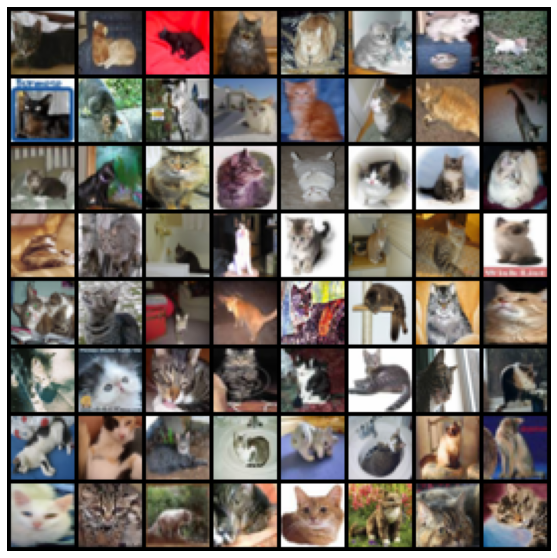

In [ ]:
# Real images exploration
visualization_batch = real_images[:64]

visualize_batch(visualization_batch.cpu())


# Model WDCGAN-GP

In [ ]:
# Filter parameters of the convNN
gen_filters = (1024, 512, 256)
disc_filters = (256, 512, 1024)

leaky_relu_alpha = 0.2

input_latent_vector_size = 100

# Training parameters

batch_size = 64
epochs = 500

lr = 1e-4
opt_betas = (0.5, 0.999)

img_size = 32
img_channels = 3

real_label = 1
synth_label = -1

generator_overtrain = 1
critic_overtrain = 5

gradient_penalty_lambda = 10


# Storage and visualization parameters
check_interval = 50
storage_interval = 100


# Generator

In [ ]:
class Generator(nn.Module):
    def __init__(self, filter_sizes, leaky_relu_alpha, input_lantent_vector_size, bias=True, bnorm_affine=True):
        super(Generator, self).__init__()
      
        # Network architecture
        # Input Tconv | out:[512 x 512 x 1024]
        self.input = nn.Sequential(
            nn.ConvTranspose2d(in_channels = input_lantent_vector_size, out_channels = filter_sizes[0], kernel_size = 4, stride = 1, padding = 0, bias = bias),
            nn.BatchNorm2d(num_features=filter_sizes[0], affine = bnorm_affine),
            nn.ReLU(inplace = True))
        
        # Hidden Tconv 1 | out:[256 x 256 x 512]
        self.hidden_tconv_1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=filter_sizes[0], out_channels = filter_sizes[1], kernel_size = 4, stride = 2, padding = 1, bias = bias),
            nn.BatchNorm2d(num_features = filter_sizes[1], affine=bnorm_affine),
            nn.ReLU(inplace = True))

        # Input Tconv 2 | out:[128 x 128 x 256]
        self.hidden_tconv_2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels = filter_sizes[1], out_channels = filter_sizes[2], kernel_size = 4, stride = 2, padding = 1, bias = bias),
            nn.BatchNorm2d(num_features = filter_sizes[2], affine = bnorm_affine),
            nn.ReLU(inplace = True))
  
        
        # Output Tconv | out:[32 x 32 x 64]
        self.output = nn.Sequential(
            nn.ConvTranspose2d(in_channels = filter_sizes[2], out_channels = 3, kernel_size = 4, stride = 2, padding = 1, bias = bias),
            nn.Tanh())
        
        self.input_lantent_vector_size = input_lantent_vector_size

    def forward(self, x):
        features = self.input(x)
        
        features = self.hidden_tconv_1(features)
        features = self.hidden_tconv_2(features)
       

        output = self.output(features)

        return output

# Descriminator


In [ ]:
# we do not use 
class Critic(nn.Module):
    def __init__(self, filter_sizes, leaky_relu_alpha, bias=True):
        super(Critic, self).__init__()

        # Network architecture
        # Input conv | output:[16 x 16 x 64] | LeakyReLu to ensure we do not kill the gradient!
        self.input = nn.Sequential (
            nn.Conv2d(in_channels = img_channels, out_channels = filter_sizes[0], kernel_size = 4, stride = 2, padding = 1, bias = bias),
            nn.LeakyReLU(leaky_relu_alpha, inplace=True)) 
        
        # Hidden conv 1 | output:[8 x 8 x 128]
        self.hidden_conv_1 = nn.Sequential(
            nn.Conv2d(in_channels = filter_sizes[0], out_channels = filter_sizes[1], kernel_size = 4, stride = 2, padding = 1, bias = bias),
            nn.LeakyReLU(leaky_relu_alpha, inplace = True))
        
        # Hidden conv 2  | output:[4 x 4 x 256]
        self.hidden_conv_2 = nn.Sequential(
            nn.Conv2d(in_channels = filter_sizes[1], out_channels = filter_sizes[2], kernel_size = 4, stride = 2, padding = 1, bias = bias),
            nn.LeakyReLU(leaky_relu_alpha, inplace = True))
         
        # Out conv | output:[1 x 1 x 1]
        self.output = nn.Sequential(
            nn.Conv2d(in_channels = filter_sizes[2], out_channels = 1, kernel_size = 4, stride = 1, padding = 0, bias = bias))



    def forward(self, x):
        features = self.input(x)

        features = self.hidden_conv_1(features)
        features = self.hidden_conv_2(features)
        output = self.output(features)

        return output
        

In [ ]:
#weight initialization normal distribution

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv2d') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm2d') != -1 and m.weight is not None:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


In [ ]:
generator = Generator(gen_filters, leaky_relu_alpha = leaky_relu_alpha, input_lantent_vector_size = 100)
critic = Critic(disc_filters, leaky_relu_alpha = leaky_relu_alpha)

generator = cuda(generator)
critic = cuda(critic)

generator_losses = []
critic_losses = []

initial_epoch = 0

In [ ]:
print(generator)

Generator(
  (input): Sequential(
    (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (hidden_tconv_1): Sequential(
    (0): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (hidden_tconv_2): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (output): Sequential(
    (0): ConvTranspose2d(256, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): Tanh()
  )
)


In [ ]:
print(critic)

Critic(
  (input): Sequential(
    (0): Conv2d(3, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (hidden_conv_1): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (hidden_conv_2): Sequential(
    (0): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (output): Sequential(
    (0): Conv2d(1024, 1, kernel_size=(4, 4), stride=(1, 1))
  )
)


In [ ]:
# Tensors to control the sign of the gradients during backward propagation
one = cuda(torch.tensor(1, dtype = torch.float))
mone = cuda(one * -1)

optimizer_generator = optim.Adam(generator.parameters(), lr = lr, betas = opt_betas)
optimizer_critic = optim.Adam(critic.parameters(), lr = lr, betas = opt_betas)

In [ ]:
def load_training_checkpoint(): 
    checkpoint_path = os.path.join('../input/wdcgan-gp-cifar10-cats-with-pytorch/checkpoints', 'checkpoint', 'checkpoint.pickle')
    checkpoint = torch.load(checkpoint_path)
    
    generator.load_state_dict(checkpoint['generator'])
    critic.load_state_dict(checkpoint['critic'])
    optimizer_generator.load_state_dict(checkpoint['optimizer_generator'])
    optimizer_critic.load_state_dict(checkpoint['optimizer_critic'])

    global initial_epoch 
    global generator_losses
    global critic_losses

    initial_epoch = checkpoint['epoch']
    generator_losses = checkpoint['generator_losses']
    critic_losses = checkpoint['critic_losses']

In [ ]:
if not os.path.exists('wdcgan-gp-cifar10-cats-with-pytorch/checkpoints'):
                    os.makedirs('wdcgan-gp-cifar10-cats-with-pytorch/checkpoints')

In [ ]:
try:
    load_training_checkpoint()
    print("Model",
          "\nCurrent training status:",
          "\n\tEpoch: {}".format(initial_epoch),
          "\n\tGenerator Loss: {}".format(generator_losses[-1]),
          "\n\tWasserstein Loss: {}".format(critic_losses[-1]))
    
    epochs = initial_epoch + epochs
except:
    print("No model found")
    critic.apply(weights_init)
    generator.apply(weights_init)

In [ ]:
# Fixed input vector to check the progress of the algorithm
fixed_input_vector = torch.randn(64, input_latent_vector_size, 1, 1)

fixed_input_vector = cuda(fixed_input_vector)

In [ ]:
#calculate the gradient penalty for the Wasserstein loss function according to the paper
def calculate_gradient_penalty(D, real_data, synth_data, batch_size, gp_lambda):
    alpha = torch.FloatTensor(batch_size, 1, 1, 1).uniform_(0,1)
    alpha = alpha.expand(batch_size, real_images.size(1), real_images.size(2), real_images.size(3))
    alpha = cuda(alpha.contiguous().view(batch_size, 3, 32, 32))
    
    interpolates = cuda(alpha * real_data + ((1 - alpha) * synth_data))
    interpolates = autograd.Variable(interpolates, requires_grad=True)

    critic_interpolates = D(interpolates)

    grad_outputs = cuda(torch.ones(critic_interpolates.size()))

    gradients = autograd.grad(outputs = critic_interpolates, inputs = interpolates,
                              grad_outputs = grad_outputs, create_graph = True, 
                              retain_graph = True, only_inputs = True)[0]
                              
    gradient_penalty = ((gradients.norm(2, dim = 1) - 1) ** 2).mean() * gp_lambda
    
    return gradient_penalty

In [ ]:
# Training the generator
def train_generator():
    for p in critic.parameters():
        p.requires_grad = False

    # Data preparation
    input_latent_vector = cuda(torch.randn(batch_size, input_latent_vector_size, 1, 1))

    synth_batch = generator(input_latent_vector)
    labels = torch.full((batch_size,), real_label, dtype=torch.float)
    
    synth_batch = cuda(synth_batch)
    labels = cuda(labels)
    
    # Gradient values cleaning
    generator.zero_grad()

    # Batch processing
    output = critic(synth_batch).view(-1)

    # Loss calculation
    loss = output.mean()

    # Gradient propagation
    loss.backward(mone)

    # Weight update (Learning the weights optimizing the direction of gradient!)
    optimizer_generator.step()
    
    return loss


In [ ]:
def train_critic(real_batch):
    for p in critic.parameters():
        p.requires_grad = True

  
    input_latent_vector = cuda(torch.randn(batch_size, input_latent_vector_size, 1, 1))

    synth_batch = generator(input_latent_vector)
    synth_batch = cuda(synth_batch)

    real_labels = torch.full((batch_size,), real_label, dtype=torch.float)
    real_labels = cuda(real_labels)
    synth_labels = torch.full((batch_size,), synth_label, dtype=torch.float)
    synth_labels = cuda(synth_labels)

    # Gradient values cleaning
    critic.zero_grad()

    # Batch processing
    output = critic(real_batch).view(-1)

    # Loss calculation
    loss_real = output.mean()

    # Gradient propagation
    loss_real.backward(mone)

    # Batch processing
    output = critic(synth_batch).view(-1)

    # Loss calculation
    loss_synth = output.mean()

    # Gradient backward propagation
    loss_synth.backward(one)
    
    # Gradient penalty term calculation
    gradient_penalty = calculate_gradient_penalty(critic, real_batch, synth_batch, batch_size, gradient_penalty_lambda)
    
    # Gradient propagation
    gradient_penalty.backward()
 
    # Weight update (Learning happening!)
    optimizer_critic.step()

    return loss_synth - loss_real + gradient_penalty 

# Trainning 


Training log: Start [12:14:02] Starting epoch: 0 (-> 500)
Training log: Epoch 0 done [12:14:43]
Epoch elapsed time: 0:00:40.389886 [Total elapsed time 0:00:40.391320]
Generator loss: -15241.400390625 
Wasserstein loss: -17549.93359375


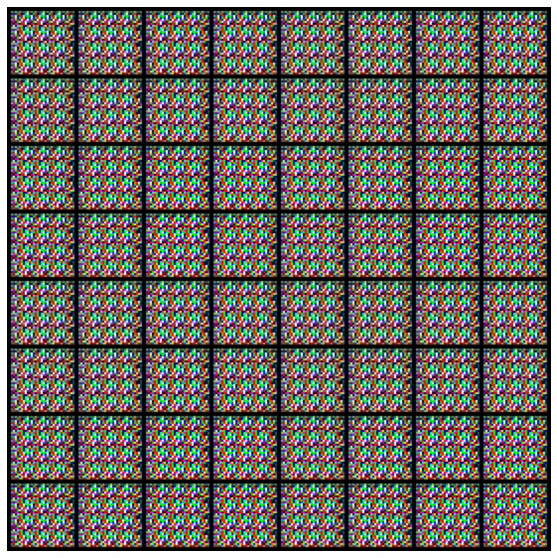

Training log: Epoch 50 done [12:48:34]
Epoch elapsed time: 0:00:40.596075 [Total elapsed time 0:34:31.347937]
Generator loss: 18355.16796875 
Wasserstein loss: -708.0703125


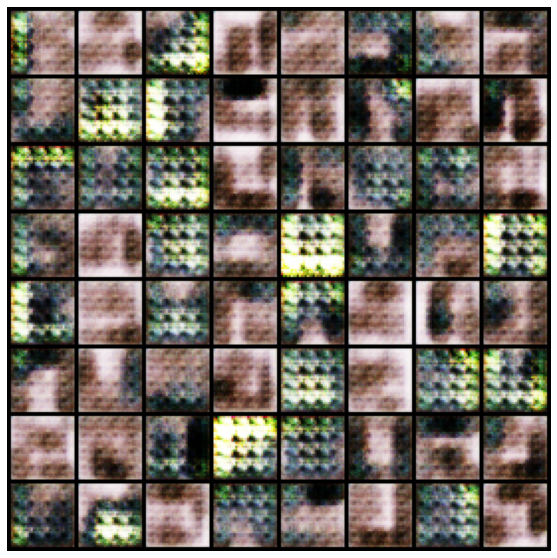

Training log: Epoch 100 done [13:22:24]
Epoch elapsed time: 0:00:40.459780 [Total elapsed time 1:08:22.068732]
Generator loss: -1207.315185546875 
Wasserstein loss: -403.49896240234375


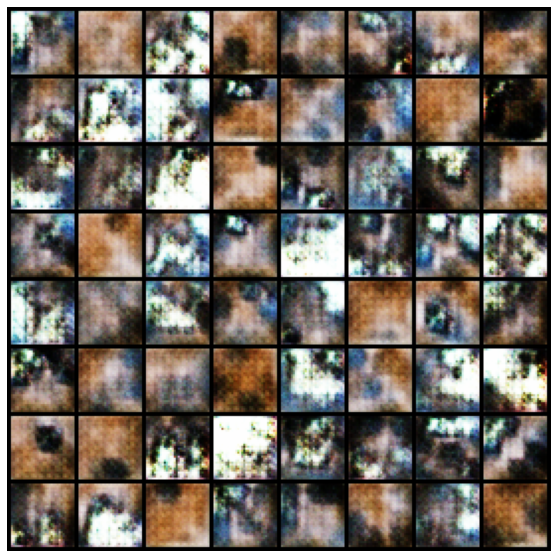

Training log: Epoch 150 done [13:56:09]
Epoch elapsed time: 0:00:40.756500 [Total elapsed time 1:42:06.610565]
Generator loss: -5372.94189453125 
Wasserstein loss: -421.8241882324219


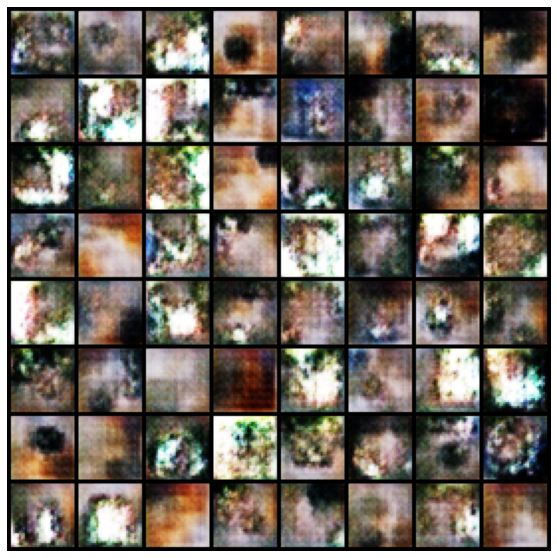

Training log: Epoch 200 done [14:30:02]
Epoch elapsed time: 0:00:40.702810 [Total elapsed time 2:15:59.381485]
Generator loss: 3257.376708984375 
Wasserstein loss: -280.22271728515625


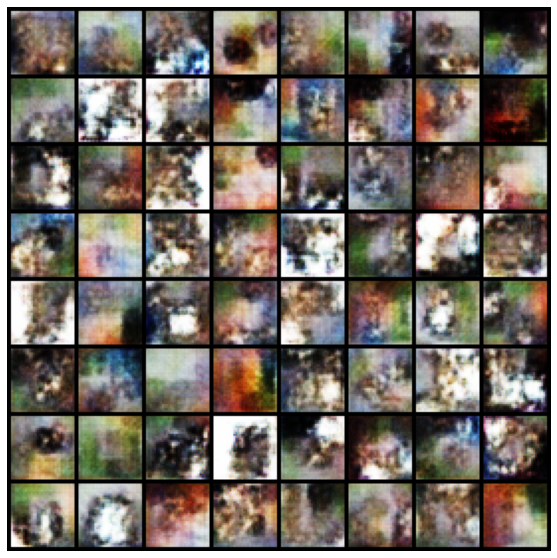

Training log: Epoch 250 done [15:03:54]
Epoch elapsed time: 0:00:40.631370 [Total elapsed time 2:49:51.591672]
Generator loss: -3018.5634765625 
Wasserstein loss: -244.5045166015625


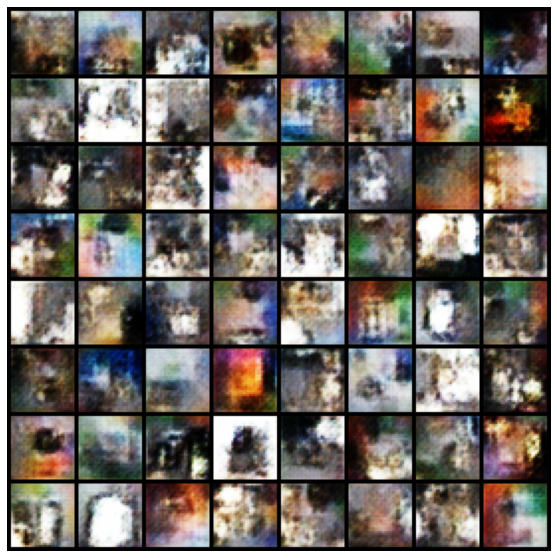

Training log: Epoch 300 done [15:37:47]
Epoch elapsed time: 0:00:40.656144 [Total elapsed time 3:23:44.716488]
Generator loss: -2894.35107421875 
Wasserstein loss: -290.7445373535156


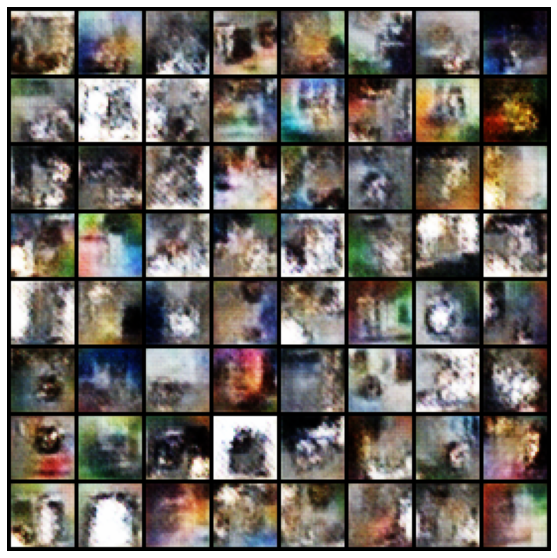

Training log: Epoch 350 done [16:11:35]
Epoch elapsed time: 0:00:40.750872 [Total elapsed time 3:57:32.351954]
Generator loss: 1026.916259765625 
Wasserstein loss: -392.6544494628906


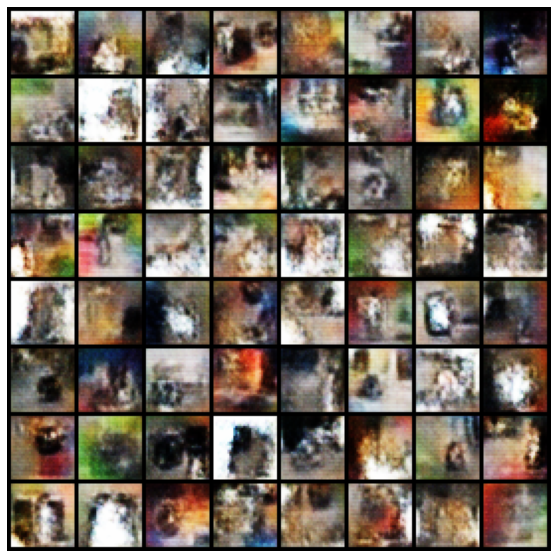

Training log: Epoch 400 done [16:45:27]
Epoch elapsed time: 0:00:40.715556 [Total elapsed time 4:31:24.916027]
Generator loss: 1937.0948486328125 
Wasserstein loss: -142.93710327148438


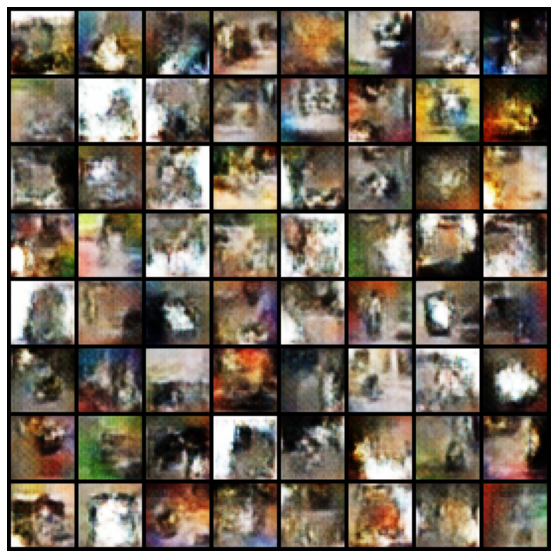

Training log: Epoch 450 done [17:19:21]
Epoch elapsed time: 0:00:40.635220 [Total elapsed time 5:05:18.678323]
Generator loss: 408.8354187011719 
Wasserstein loss: -323.4815673828125


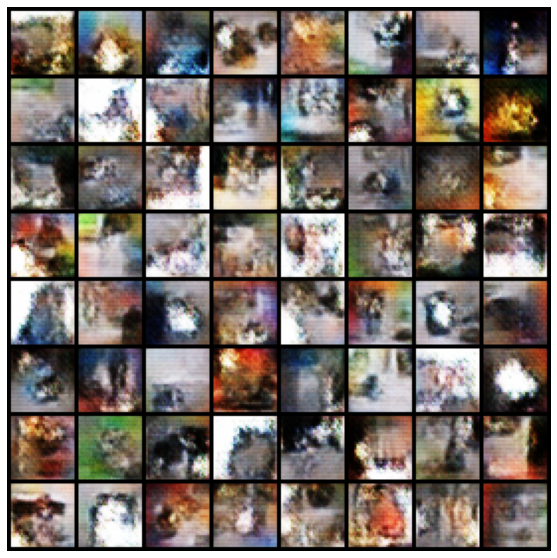

Training log: Epoch 500 done [17:53:15]
Epoch elapsed time: 0:00:40.690423 [Total elapsed time 5:39:12.819652]
Generator loss: 218.0465087890625 
Wasserstein loss: -188.16464233398438


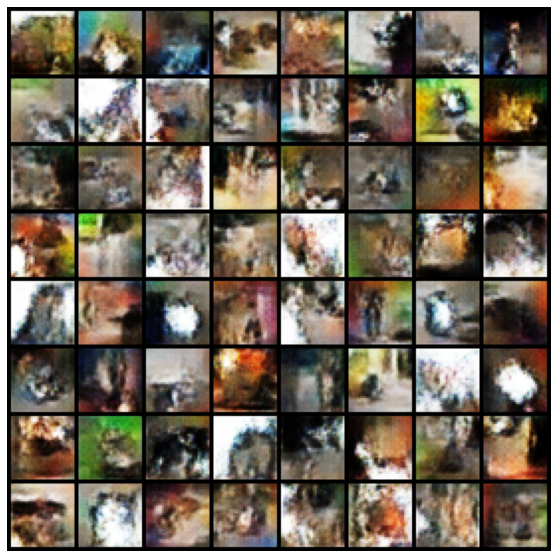

In [ ]:
# Train discriminator more than the generator, according to the paper
iters_per_epoch = len(real_images) // (batch_size * critic_overtrain)

start_time = datetime.now()

checkpoint_path = os.path.join(ModelStorage, 'checkpoint')
os.makedirs(checkpoint_path, exist_ok = True)

print("Training log: Start [{}] Starting epoch: {} (-> {})".format(start_time.strftime("%H:%M:%S"), initial_epoch, epochs))

for epoch in range(initial_epoch, epochs+1):
    epoch_idx = torch.randperm(real_images.size(0))
    epoch_start_time = datetime.now()

    for i in range(iters_per_epoch): #iters_per_epoch = 18

        for j in range(critic_overtrain): # critric_overtrain = 5
            iter_idx = epoch_idx[(i+j)*batch_size : (i+j+1)*batch_size]
            real_batch = real_images[iter_idx]

            loss_critic = train_critic(real_batch)
        
        for _ in range(generator_overtrain): 
            loss_generator = train_generator()

    generator_losses.append(loss_generator)
    critic_losses.append(loss_critic)

    if epoch % check_interval == 0:
        elapsed_time =  "\nEpoch elapsed time: {} [Total elapsed time {}]".format(datetime.now() - epoch_start_time, datetime.now() - start_time)
        losses_print = "\nGenerator loss: {} \nWasserstein loss: {}".format(loss_generator, loss_critic)

        print("Training log: Epoch {} done [{}]{}{}".format(epoch, datetime.now().strftime("%H:%M:%S"), elapsed_time, losses_print))

        # Visualize status of generation
        visualization_batch = generator(fixed_input_vector)
        visualize_batch(visualization_batch.cpu().detach(), True, epoch)
    
    if epoch % storage_interval == 0:
        # Model state storage
        storage_path = os.path.join(checkpoint_path, "checkpoint.pickle".format(epoch))
        storage_dict = {'epoch': epoch,
                        'generator_losses': generator_losses,
                        'critic_losses' : critic_losses,
                        'generator': generator.state_dict(),
                        'critic': critic.state_dict(),
                        'optimizer_generator': optimizer_generator.state_dict(),
                        'optimizer_critic': optimizer_critic.state_dict()}

        torch.save(storage_dict, storage_path)
        
    initial_epoch = epoch

# Plot Losses

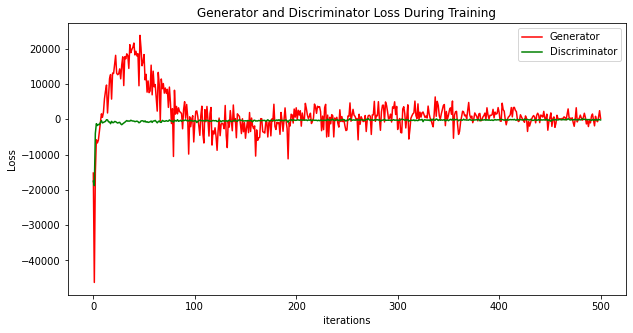

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(generator_losses, 'r', label="Generator")
plt.plot(critic_losses, 'g', label="Discriminator")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
#Visualization of real images vs. fake images at the last epoch
def visualize_batch_R_F(batch1, batch2, save = False, epoch = 0):
  batchR = image_visualization_pretreatment(batch1)
  batchF = image_visualization_pretreatment(batch2)
  plt.figure(figsize = (15,15))
  plt.subplot(1,2,1)
  plt.axis("off")
  plt.title("Real Images")
  plt.imshow(np.transpose(vutils.make_grid(batchR, padding = 2, normalize = True), (1,2,0)))
  plt.subplot(1,2,2)
  plt.axis("off")
  plt.title("Fake Images")
  plt.imshow(np.transpose(vutils.make_grid(batchF, padding = 2, normalize = True), (1,2,0)))
  if save:
    if not os.path.exists('./output/synth_imgs'):
      os.makedirs('./output/synth_imgs')
      plt.savefig("output/synth_imgs/{} : epoch {}.png".format(datetime.now().strftime("%H:%M:%S"), epoch))

      plt.show()  

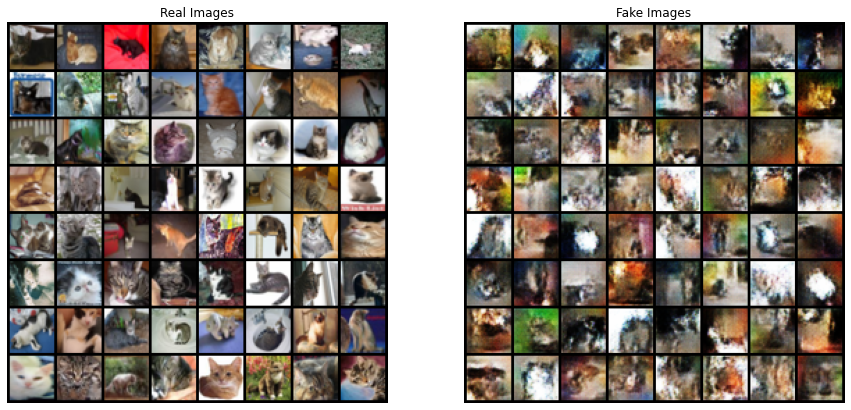

In [ ]:
#fake image last epoch
visualization_batchF = generator(fixed_input_vector)

# Real image
visualization_batchR = real_images[:64]

visualize_batch_R_F(visualization_batchR.cpu(), visualization_batchF.cpu().detach(), True, 500)